In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import os
import glob

# Load Config

In [2]:
import configparser

# Load the configuration file
config = configparser.ConfigParser()
config.read('cfg.ini')

# Paths
train_data_path = config['Paths']['TrainData']
test_data_path = config['Paths']['TestData']

# Data
batch_size = int(config['Data']['BatchSize'])

# Device
device = config['Device']['device']

# Pooling
pool1_size = int(config['Pooling']['Pool1size'])
pool1_stride = int(config['Pooling']['Pool1Stride'])
pool2_size = int(config['Pooling']['Pool2size'])
pool2_stride = int(config['Pooling']['Pool2Stride'])
pool3_size = int(config['Pooling']['Pool3size'])
pool3_stride = int(config['Pooling']['Pool3Stride'])

# Convolutional Layers
kernel_size1 = int(config['Conv']['KernelSize1'])
kernel_size2 = int(config['Conv']['KernelSize2'])
kernel_size3 = int(config['Conv']['KernelSize3'])
kernel_size4 = int(config['Conv']['KernelSize4'])
kernel_size5 = int(config['Conv']['KernelSize5'])
conv1_in = int(config['Conv']['Conv1in'])
conv1_out = int(config['Conv']['Conv1out'])
conv2_in = int(config['Conv']['Conv2in'])
conv2_out = int(config['Conv']['Conv2out'])
conv3_in = int(config['Conv']['Conv3in'])
conv3_out = int(config['Conv']['Conv3out'])
conv4_in = int(config['Conv']['Conv4in'])
conv4_out = int(config['Conv']['Conv4out'])
conv5_in = int(config['Conv']['Conv5in'])
conv5_out = int(config['Conv']['Conv5out'])

# Linear Layers
l1_in = int(config['Linear']['L1in'])
l1_out = int(config['Linear']['L1out'])
l2_in = int(config['Linear']['L2in'])
l2_out = int(config['Linear']['L2out'])
l3_in = int(config['Linear']['L3in'])
l3_out = int(config['Linear']['L3out'])

# View
v1 = int(config['View']['V1'])
v2 = int(config['View']['V2'])

# Training
num_epochs = int(config['Training']['NumEpochs'])
learning_rate = float(config['Training']['LearningRate'])

# Using the values
print(f"Training Data Path: {train_data_path}")
print(f"Test Data Path: {test_data_path}")
print(f"Batch Size: {batch_size}")
print(f"Device: {device}")
print(f"Number of Epochs: {num_epochs}")
print(f"Learning Rate: {learning_rate}")
# Add more print statements as needed to display other configurations


Training Data Path: ./data/train
Test Data Path: ./data/test
Batch Size: 128
Device: cuda
Number of Epochs: 10
Learning Rate: 0.0005


# Load The Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


# Design your own Network

# DLA

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(DLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = DLA()
    print(net)
    x = torch.randn(1, 3, 32, 32)
    y = net(x)
    print(y.size())


if __name__ == '__main__':
    test()

DLA(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left_node): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1

# ResNet

In [5]:
# class BasicBlock(nn.Module):
#     expansion = 1
# 
#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(
#             in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
# 
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )
# 
#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out
# 
# 
# class Bottleneck(nn.Module):
#     expansion = 4
# 
#     def __init__(self, in_planes, planes, stride=1):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                                stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, self.expansion *
#                                planes, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(self.expansion*planes)
# 
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )
# 
#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = F.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out
# 
# 
# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet, self).__init__()
#         self.in_planes = 64
# 
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)
# 
#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)
# 
#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out
# 
# 
# def ResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
# 
# 
# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])
# 
# 
# def ResNet50():
#     return ResNet(Bottleneck, [3, 4, 6, 3])
# 
# 
# def ResNet101():
#     return ResNet(Bottleneck, [3, 4, 23, 3])
# 
# 
# def ResNet152():
#     return ResNet(Bottleneck, [3, 8, 36, 3])
# 
# 
# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())
# 
# # test()

# Define Model


In [6]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(conv1_in, conv1_out, kernel_size = kernel_size1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool1_size, pool1_stride),
            
            nn.Conv2d(conv2_in, conv2_out, kernel_size = kernel_size2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(conv3_in, conv3_out, kernel_size = kernel_size3),
            nn.MaxPool2d(pool2_size, pool2_stride),
            
            nn.Conv2d(conv4_in, conv4_out, kernel_size = kernel_size4, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(conv5_in, conv5_out, kernel_size = kernel_size5, padding=1),
            nn.MaxPool2d(kernel_size=pool3_size, stride=pool3_stride)
            
        )

        self.classifier = nn.Sequential(
            nn.Linear(l1_in * 6 * 6, l1_out),
            nn.ReLU(inplace=True),
            nn.Linear(l2_in, l2_out),
            nn.ReLU(inplace=True),
            nn.Linear(l3_in, l3_out)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(v1, v2 * 6 * 6)
        x = self.classifier(x)
        
        return x

# Model Training


In [7]:
model = DLA()
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []
for epoch in range(num_epochs):
    loss_per_epoch = 0
    for images, label in trainloader:
        optimizer.zero_grad()

        images, label = images.to(device), label.to(device)

        outputs = model(images)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss

    print(f"epoch: {epoch + 1} / {num_epochs}, loss_per_epoch: {loss_per_epoch}")
    loss_history.append(loss_per_epoch.cpu().detach().numpy())

# Question: Why I increase the batch size, the loss_per_epoch will decrease?
# Write your answer here.

epoch: 1 / 10, loss_per_epoch: 512.1892700195312
epoch: 2 / 10, loss_per_epoch: 320.4618225097656
epoch: 3 / 10, loss_per_epoch: 237.1293487548828
epoch: 4 / 10, loss_per_epoch: 187.32826232910156
epoch: 5 / 10, loss_per_epoch: 152.0181121826172
epoch: 6 / 10, loss_per_epoch: 117.43788146972656
epoch: 7 / 10, loss_per_epoch: 89.4163818359375
epoch: 8 / 10, loss_per_epoch: 71.31609344482422
epoch: 9 / 10, loss_per_epoch: 54.68770980834961
epoch: 10 / 10, loss_per_epoch: 45.1429443359375


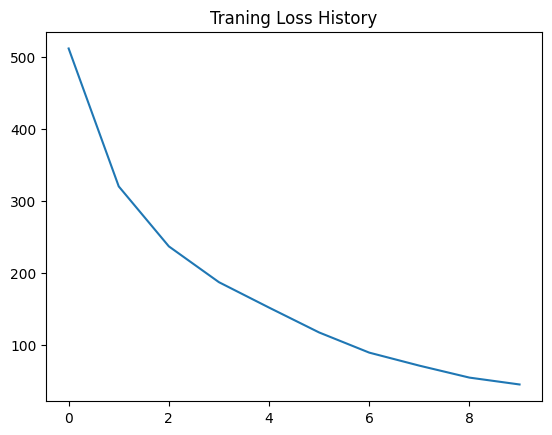

In [9]:
plt.plot(list(range(num_epochs)), loss_history)
plt.title("Traning Loss History")
plt.show()

# Model Testing

In [10]:
# Test the model and show some predictions
correct = 0
total = 0

with torch.no_grad():
    for images, label in testloader:
        images, label = images.to(device), label.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f"Test Accuracy: {correct/total}")

Test Accuracy: 0.8252203525641025


In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

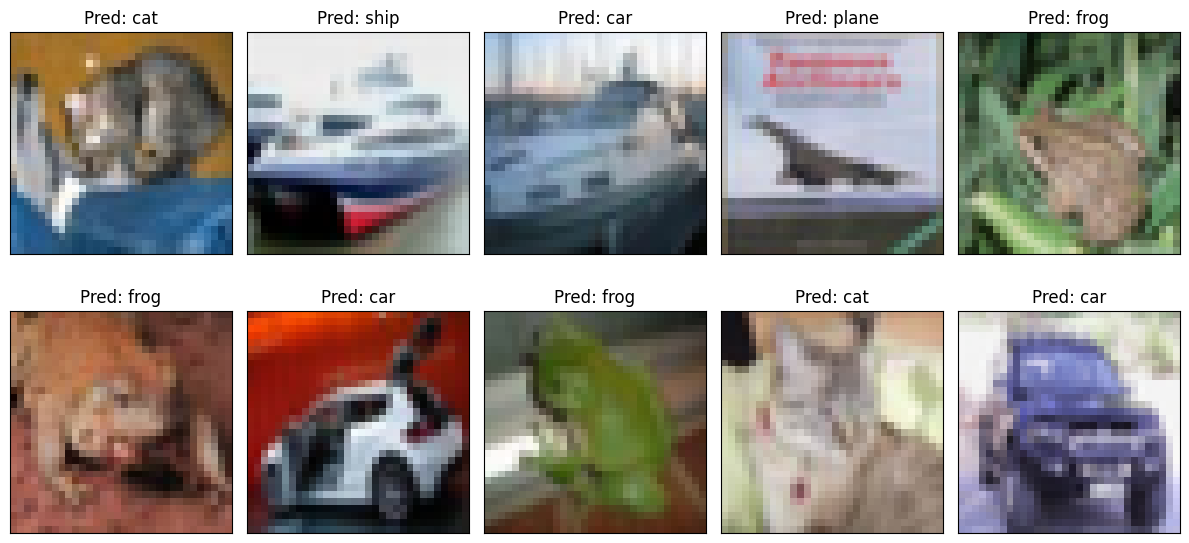

In [12]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

# Predict
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)) * 0.5 + 0.5)
    ax.set_title('Pred: %s' % classes[predicted[i]])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Logging

In [13]:
import logging
import configparser
from datetime import datetime
log_directory = '/home/vglalala/PycharmProjects/AIProject/log'
# Set up basic configuration for logging
logging.basicConfig(filename=f'{log_directory}/project_log_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.log',
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Function to log the configuration settings
def log_config(config_path):
    config = configparser.ConfigParser()
    config.read(config_path)
    for section in config.sections():
        for key in config[section]:
            logging.info(f"CONFIG - {section} - {key}: {config[section][key]}")

# Example function to log training progress
def log_training(epoch, loss_per_epoch):
    """Log the loss per epoch during training."""
    logging.info(f"TRAINING - Epoch: {epoch}, Loss per Epoch: {loss_per_epoch}")


logging.info(f"TEST - Accuracy: {correct/total}")


# Assuming you have a config file named 'settings.ini'
log_config('cfg.ini')

for i in range(1,num_epochs+1):
    loss = loss_history[i-1]
    log_training(i,loss)